# Hace tu visualizacion!
> Después del último post varias personas se acercaron con ideas para probar...

- toc: false 
- badges: true
- comments: false
- categories: [tutorial]
- image: images/infected-and-growth.png

... asi que aqui vamos!

Para los posts anteriores utilicé los **datos** de la universidad de [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) y los [datos publicados nacionales](https://www.argentina.gob.ar/coronavirus/informe-diario), que a diferencia de los de Johns Hopkins, está abierta por provincias

Los datos abiertos por provincias provienen de un **scrapper que la saca de los PDFs**. Los primeros informes no seguian un patron tan sencillo para extraer, y luego estandarizaron en una enumeracion. Como los casos de los primeros informes eran unos pocos, el scrapper los desestima.

En este post, intencionalmente **no oculté las celdas**. 

En las notebooks de otros posts oculté el código por una cuestion de legibilidad. Si entran en [este](https://github.com/elsonidoq/covid-19-argentina/blob/master/_notebooks/2020-03-24-visualizando-los-datos-del-informe-diario.ipynb), van a ver dice `#hide` en muchas cells. Eso hace que se oculte al hacer el post

Para ver la documentación sobre como colaborar, pueden ir a [fastpages](https://fastpages.fast.ai/).


In [1]:
# voy a usar tanto matplotlib, altair y seaborn... porque se puede!
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import pandas as pd
import numpy as np

# Estos files estan en el repo
import arg_data
import global_data

sns.set(style='whitegrid')

## Cargamos los dataframes

In [2]:
# Baja los PDFs, los guarda en la carpeta cache y los lee
arg_df = arg_data.get_arg_df()

# Accede a la data de JH
global_df = global_data.get_global_covid_df()

In [3]:
arg_df.head()

,place,infered_place,infered_place_score,infected,date,days_from_first_infection,cum_infected
87,Ciudad de Buenos Aires,Ciudad autonoma de Buenos Aires,1.0,2,2020-03-13,0,2
83,Ciudad Autónoma de Buenos Aires,Ciudad autonoma de Buenos Aires,1.0,5,2020-03-16,3,7
74,Ciudad Autónoma de Buenos Aires,Ciudad autonoma de Buenos Aires,1.0,4,2020-03-17,4,11
69,Ciudad Autónoma de Buenos Aires,Ciudad autonoma de Buenos Aires,1.0,10,2020-03-18,5,21
64,Ciudad Autónoma de Buenos Aires,Ciudad autonoma de Buenos Aires,1.0,8,2020-03-19,6,29


In [4]:
global_df.head()

,date,country,confirmed,recovered,death,confirmed_growth_rate,death_growth_rate,first_infaction_date,days_from_first_infection,tenth_infaction_date,days_from_tenth_infection,first_death_date,days_from_first_death,tenth_death_date,days_from_tenth_death
0,2020-01-22,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-33,2020-03-14,-52.0,2020-03-22,-60.0,NaT,NaN
1,2020-01-23,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-32,2020-03-14,-51.0,2020-03-22,-59.0,NaT,NaN
2,2020-01-24,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-31,2020-03-14,-50.0,2020-03-22,-58.0,NaT,NaN
3,2020-01-25,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-30,2020-03-14,-49.0,2020-03-22,-57.0,NaT,NaN
4,2020-01-26,Afghanistan,0,0,0,1.6,1.6,2020-02-24,-29,2020-03-14,-48.0,2020-03-22,-56.0,NaT,NaN


----
### A partir de aca, podes hacer cualquier estadística que combine estos datos

Por ejemplo, evolución (interactiva!) de los paises con mas infectados

In [5]:
total_confirmed_by_country = global_df.groupby('country').confirmed.max().sort_values(ascending=False)
selected_countries = total_confirmed_by_country[total_confirmed_by_country > 1000].index

plot_df = global_df[
    (global_df.confirmed > 0) & 
    (global_df.country.isin(selected_countries[:10]))
].sort_values('date')

selection = alt.selection_multi(
    fields=['country'], 
    bind='legend', 
    init=[{'country': c} for c in selected_countries[:10]]
)


(
    alt.Chart(plot_df)
       .mark_line()
       .encode(
           x='days_from_first_infection', 
           y=alt.Y('confirmed', scale=alt.Scale(type='log')), 
           color='country',
           opacity=alt.condition(selection, alt.value(.8), alt.value(.05))
       ).add_selection(selection)
        .properties(width=650, height=400)
       
)

alt.Chart(...)

_Y si no te llevas bien con altair (como yo!), podes usar el good 'ol matplotlib_

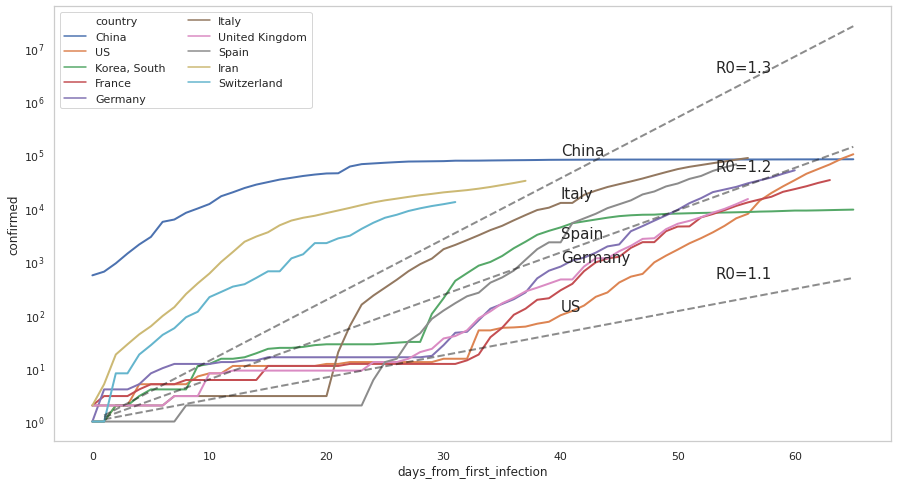

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.subplots()

sns.lineplot(
    data=plot_df, 
    x='days_from_first_infection', 
    y='confirmed', 
    hue='country',
    lw=2
)

for country in selected_countries[:5]:
    cdf = plot_df[plot_df.country == country]
    loc = min(40, len(cdf)-1)
    row = cdf.iloc[loc]
    plt.text(row.days_from_first_infection, row.confirmed * 1.2, country, fontdict=dict(size=15))

x=np.linspace(1, global_df.days_from_first_infection.max())
def plot_rate(rate):
    y = rate ** x
    ax.semilogy(x, y, 'k--', lw=2, alpha=0.5)
    plt.text(x[40], y[40] * 3, f'R0={rate}', fontdict=dict(size=15))
    

plot_rate(1.1)
plot_rate(1.2)
plot_rate(1.3)
ax.grid()
plt.legend(loc='best', ncol=2);

# Tasa de contagios por país

El color corresponde con la cantidad de casos confirmados

In [7]:
today_df = global_df[
    (global_df.date == global_df.date.max()) & 
    (global_df.confirmed > 1000)
]


alt.Chart(today_df).mark_bar().encode(
    x=alt.X(
        'country', 
        sort=list(
            today_df.set_index('country')
                    .confirmed_growth_rate
                    .sort_values()
                    .index[::-1]
        )
    ),
    y=alt.X(
        'confirmed_growth_rate', 
        scale=alt.Scale(domain=[1, 1.6], clamp=True)
    ),
    color=alt.Color('confirmed', scale=alt.Scale(type='log')),
    tooltip=list(today_df.columns)
)

alt.Chart(...)